In [1]:
import pydot
import matplotlib.pyplot as plt
import time
import math
import random
from sklearn.manifold import MDS
import numpy as np
import plotly.graph_objs as go
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap


In [2]:
def get_data_step6(dot_file_path): #nodes,edges,node_list,edge_list,weights
    '''Returns the nodes, edges (both in pydot format), a list with all the nodes and another with all the edges, and also a dic with (edge):weigth
    '''
     #= 'Datasets/LesMiserables.dot'
    with open(dot_file_path, 'r') as dot_file:
        dot_data = dot_file.read()
    graph = pydot.graph_from_dot_data(dot_data)

    nodes = graph[0].get_nodes()
    edges = graph[0].get_edges()
    
    node_list = [node.get_name() for node in nodes]
    edge_list = [(edge.get_source(), edge.get_destination()) for edge in edges]
    weights = {}
    if edges[0].get_attributes()!={}:
        name= str(list(edges[0].get_attributes().keys())[0])
        weights = {(edge.get_source(), edge.get_destination()):int(edge.get_attributes()[name]) for edge in edges}

    return nodes,edges,node_list,edge_list,weights

In [3]:
def get_data_league(dot_file_path):
    '''Returns the nodes, edges (both in pydot format), a list with all the nodes and another with all the edges, and also a dic with (edge):weight
    '''
    with open(dot_file_path, 'r') as dot_file:
        dot_data = dot_file.read()
    graph = pydot.graph_from_dot_data(dot_data)

    nodes = graph[0].get_nodes()
    edges = graph[0].get_edges()
    
    node_list = [node.get_name() for node in nodes]
    edge_list = [(edge.get_source(), edge.get_destination()) for edge in edges]
    weights = {}
    if edges[0].get_attributes() != {}:
        name = str(list(edges[0].get_attributes().keys())[0])
        weights = {(edge.get_source(), edge.get_destination()): int(edge.get_attributes()[name].strip('"')) for edge in edges}

    return nodes, edges, node_list, edge_list, weights

In [4]:
nodes,edges,node_list,edge_list,weights = get_data_league('Datasets/LeagueNetwork.dot')

print("nodes", nodes)
print("edges", nodes)
print("node_list", node_list)
print("edges_list", edge_list)
print("weights", weights)

nodes [<pydot.core.Node object at 0x14fb18090>, <pydot.core.Node object at 0x14fb1b9d0>, <pydot.core.Node object at 0x15004a410>, <pydot.core.Node object at 0x15036b510>, <pydot.core.Node object at 0x15036aa50>, <pydot.core.Node object at 0x15040d450>, <pydot.core.Node object at 0x15040dd10>, <pydot.core.Node object at 0x15040dbd0>, <pydot.core.Node object at 0x1503dded0>, <pydot.core.Node object at 0x150204350>, <pydot.core.Node object at 0x15013edd0>, <pydot.core.Node object at 0x15013cc50>, <pydot.core.Node object at 0x150576bd0>, <pydot.core.Node object at 0x1505770d0>, <pydot.core.Node object at 0x14fb1b750>, <pydot.core.Node object at 0x14fb1b410>]
edges [<pydot.core.Node object at 0x14fb18090>, <pydot.core.Node object at 0x14fb1b9d0>, <pydot.core.Node object at 0x15004a410>, <pydot.core.Node object at 0x15036b510>, <pydot.core.Node object at 0x15036aa50>, <pydot.core.Node object at 0x15040d450>, <pydot.core.Node object at 0x15040dd10>, <pydot.core.Node object at 0x15040dbd0>, <p

# Similarity Matrix

In [5]:
def compute_similarity_matrix(node_list, edge_list, weights):
    edge_weights = {(u, v): weight for (u, v), weight in weights.items()}

    num_nodes = len(node_list)
    distances = np.zeros((num_nodes, num_nodes))
    for i, source in enumerate(node_list):
        for j, target in enumerate(node_list):
            if i != j:
                if (source, target) in edge_weights:
                    distances[i, j] = edge_weights[(source, target)]
                elif (target, source) in edge_weights:
                    distances[i, j] = edge_weights[(target, source)]
                else:
                    distances[i, j] = np.inf

    similarities = np.zeros((num_nodes, num_nodes))
    for u, v in edge_list:
        i = node_list.index(u)
        j = node_list.index(v)
        similarities[i, j] = 1 / (1 + distances[i, j])
        similarities[j, i] = similarities[i, j]  # Similarity matrix is symmetric

    np.fill_diagonal(similarities, 1) #diagonal 1

    return similarities

similarity_matrix = compute_similarity_matrix(node_list, edge_list, weights)

print("Similarity matrix:")
print("\t" + "\t".join(node_list))
for i in range(len(node_list)):
    print(node_list[i], "\t", end="")
    for j in range(len(node_list)):
        print("{:.2f}".format(similarity_matrix[i, j]), "\t", end="")
    print()


Similarity matrix:
	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16
1 	1.00 	1.00 	0.33 	0.50 	0.50 	1.00 	0.50 	0.50 	-0.50 	0.50 	-1.00 	-0.50 	0.50 	inf 	inf 	-0.50 	
2 	1.00 	1.00 	inf 	-1.00 	-0.50 	0.50 	-1.00 	-1.00 	inf 	1.00 	0.50 	inf 	0.50 	1.00 	-1.00 	1.00 	
3 	0.33 	inf 	1.00 	0.33 	0.50 	1.00 	1.00 	1.00 	1.00 	1.00 	0.33 	-1.00 	inf 	0.33 	1.00 	0.50 	
4 	0.50 	-1.00 	0.33 	1.00 	0.14 	0.50 	0.25 	0.50 	0.33 	-0.50 	0.50 	1.00 	1.00 	-0.50 	-0.33 	inf 	
5 	0.50 	-0.50 	0.50 	0.14 	1.00 	1.00 	-1.00 	0.50 	1.00 	inf 	inf 	inf 	inf 	0.25 	-0.33 	0.50 	
6 	1.00 	0.50 	1.00 	0.50 	1.00 	1.00 	inf 	0.50 	0.25 	1.00 	inf 	-0.33 	-1.00 	-1.00 	inf 	-1.00 	
7 	0.50 	-1.00 	1.00 	0.25 	-1.00 	inf 	1.00 	1.00 	-0.50 	0.50 	1.00 	inf 	1.00 	inf 	0.25 	0.50 	
8 	0.50 	-1.00 	1.00 	0.50 	0.50 	0.50 	1.00 	1.00 	1.00 	1.00 	0.50 	inf 	inf 	1.00 	1.00 	1.00 	
9 	-0.50 	inf 	1.00 	0.33 	1.00 	0.25 	-0.50 	1.00 	1.00 	inf 	0.50 	0.50 	inf 	1.00 	1.00 	1.00 	
10 	0.50 	1.00 	1.00 	-0.50 	inf 	1.0

/var/folders/pp/bdyt1jrd5w5d3twfkg227dtc0000gn/T/ipykernel_40979/2364825144.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  similarities[i, j] = 1 / (1 + distances[i, j])


### Jazz

In [6]:
def compute_similarity_matrix(node_list, edge_list):
    num_nodes = len(node_list)
    
    distances = np.full((num_nodes, num_nodes), np.inf)
    
    for u, v in edge_list:
        i = node_list.index(u)
        j = node_list.index(v)
        distances[i, j] = 1
        distances[j, i] = 1  
    
    similarities = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                similarities[i, j] = 1 / (1 + distances[i, j])
    
    np.fill_diagonal(similarities, 1)
    
    return similarities

similarity_matrix = compute_similarity_matrix(node_list, edge_list)

print("Similarity matrix:")
print("\t" + "\t".join(node_list))
for i in range(len(node_list)):
    print(node_list[i], "\t", end="")
    for j in range(len(node_list)):
        print("{:.2f}".format(similarity_matrix[i, j]), "\t", end="")
    print()


Similarity matrix:
	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16
1 	1.00 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	
2 	0.50 	1.00 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	
3 	0.50 	0.50 	1.00 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	
4 	0.50 	0.50 	0.50 	1.00 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	
5 	0.50 	0.50 	0.50 	0.50 	1.00 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	
6 	0.50 	0.50 	0.50 	0.50 	0.50 	1.00 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	
7 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	1.00 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	
8 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	1.00 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	
9 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	1.00 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	
10 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0

### League

In [7]:
def compute_similarity_matrix(node_list, edge_list, weights):
    edge_weights = {(u, v): weight for (u, v), weight in weights.items()}

    num_nodes = len(node_list)
    distances = np.zeros((num_nodes, num_nodes))
    for i, source in enumerate(node_list):
        for j, target in enumerate(node_list):
            if i != j:
                if (source, target) in edge_weights:
                    distances[i, j] = edge_weights[(source, target)]
                elif (target, source) in edge_weights:
                    distances[i, j] = -edge_weights[(target, source)]  # Taking negative to convert goal difference to distance
                else:
                    distances[i, j] = np.inf

    similarities = np.zeros((num_nodes, num_nodes))
    for u, v in edge_list:
        i = node_list.index(u)
        j = node_list.index(v)
        similarities[i, j] = 1 / (1 + abs(distances[i, j]))  # Taking absolute value of distance
        similarities[j, i] = similarities[i, j]  # Similarity matrix is symmetric

    np.fill_diagonal(similarities, 1)  # Diagonal set to 1

    return similarities

similarity_matrix = compute_similarity_matrix(node_list, edge_list, weights)

print("Similarity matrix:")
print("\t" + "\t".join(node_list))
for i in range(len(node_list)):
    print(node_list[i], "\t", end="")
    for j in range(len(node_list)):
        print("{:.2f}".format(similarity_matrix[i, j]), "\t", end="")
    print()


Similarity matrix:
	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16
1 	1.00 	1.00 	0.33 	0.50 	0.50 	1.00 	0.50 	0.50 	0.25 	0.50 	0.33 	0.25 	0.50 	0.50 	0.50 	0.25 	
2 	1.00 	1.00 	0.50 	0.33 	0.25 	0.50 	0.33 	0.33 	0.50 	1.00 	0.50 	0.50 	0.50 	1.00 	0.33 	1.00 	
3 	0.33 	0.50 	1.00 	0.33 	0.50 	1.00 	1.00 	1.00 	1.00 	1.00 	0.33 	0.33 	0.50 	0.33 	1.00 	0.50 	
4 	0.50 	0.33 	0.33 	1.00 	0.14 	0.50 	0.25 	0.50 	0.33 	0.25 	0.50 	1.00 	1.00 	0.25 	0.20 	0.50 	
5 	0.50 	0.25 	0.50 	0.14 	1.00 	1.00 	0.33 	0.50 	1.00 	0.50 	0.50 	0.50 	0.50 	0.25 	0.20 	0.50 	
6 	1.00 	0.50 	1.00 	0.50 	1.00 	1.00 	0.50 	0.50 	0.25 	1.00 	0.50 	0.20 	0.33 	0.33 	0.50 	0.33 	
7 	0.50 	0.33 	1.00 	0.25 	0.33 	0.50 	1.00 	1.00 	0.25 	0.50 	1.00 	0.50 	1.00 	0.50 	0.25 	0.50 	
8 	0.50 	0.33 	1.00 	0.50 	0.50 	0.50 	1.00 	1.00 	1.00 	1.00 	0.50 	0.50 	0.50 	1.00 	1.00 	1.00 	
9 	0.25 	0.50 	1.00 	0.33 	1.00 	0.25 	0.25 	1.00 	1.00 	0.50 	0.50 	0.50 	0.50 	1.00 	1.00 	1.00 	
10 	0.50 	1.00 	1.00 	0.25 	0.50 	1.00 	0

# T-SNE

### checking convergence

Iteration 1: KL divergence = 0.2920937240123749
Iteration 2: KL divergence = 0.2920937240123749
Iteration 3: KL divergence = 0.2920937240123749
Iteration 4: KL divergence = 0.2920937240123749
Iteration 5: KL divergence = 0.2920937240123749
Iteration 6: KL divergence = 0.2920937240123749
Iteration 7: KL divergence = 0.2920937240123749
Iteration 8: KL divergence = 0.2920937240123749
Iteration 9: KL divergence = 0.2920937240123749
Iteration 10: KL divergence = 0.2920937240123749
Iteration 11: KL divergence = 0.2920937240123749
Iteration 12: KL divergence = 0.2920937240123749
Iteration 13: KL divergence = 0.2920937240123749
Iteration 14: KL divergence = 0.2920937240123749
Iteration 15: KL divergence = 0.2920937240123749
Iteration 16: KL divergence = 0.2920937240123749
Iteration 17: KL divergence = 0.2920937240123749
Iteration 18: KL divergence = 0.2920937240123749
Iteration 19: KL divergence = 0.2920937240123749
Iteration 20: KL divergence = 0.2920937240123749
Iteration 21: KL divergence =

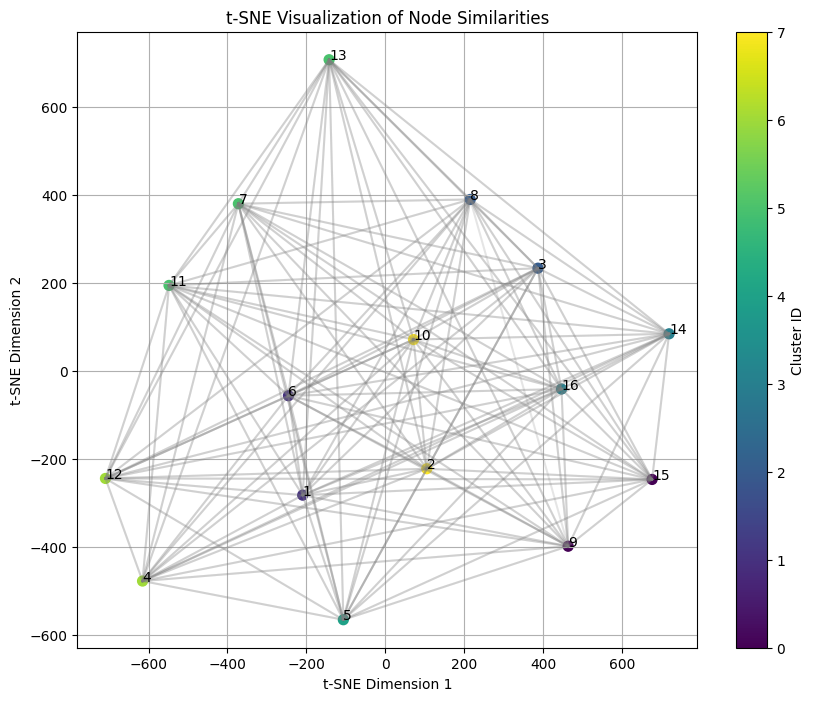

IndexError: index 2 is out of bounds for axis 1 with size 2

In [17]:
def plot_tsne(similarities, node_list, edge_list, perplexity=10, learning_rate=300, n_iter=750, interactive=False):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, init='pca')
    embeddings = tsne.fit_transform(1 - similarities)

    kl_div = tsne.kl_divergence_
    for i in range(n_iter):
        print(f"Iteration {i+1}: KL divergence = {kl_div}")
        if kl_div < 0.05:
            print(f"t-SNE has converged in iteration n. {i+1}")
            break

    kmeans = KMeans(n_clusters=8)  # You can adjust the number of clusters
    labels = kmeans.fit_predict(embeddings)

    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', s=50)

    for edge in edge_list:
        u, v = edge
        u_index = node_list.index(u)
        v_index = node_list.index(v)
        plt.plot([embeddings[u_index, 0], embeddings[v_index, 0]], 
                    [embeddings[u_index, 1], embeddings[v_index, 1]], 
                    color='gray', alpha=0.2)

    for i, node_number in enumerate(node_list):
        plt.text(embeddings[i, 0], embeddings[i, 1], node_number, color='black')

    plt.title('t-SNE Visualization of Node Similarities')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True)
    plt.colorbar(label='Cluster ID')
    plt.show()

    if interactive:
        trace = go.Scatter3d(
            x=embeddings[:, 0],
            y=embeddings[:, 1],
            z=embeddings[:, 2],
            mode='markers',
            text=node_list,
            hoverinfo='text',
            marker=dict(
                size=5,
                color=labels,
                colorscale='Viridis',
                opacity=0.8
            )
        )

        edge_traces = []
        for edge in edge_list:
            u, v = edge
            u_index = node_list.index(u)
            v_index = node_list.index(v)
            edge_trace = go.Scatter3d(
                x=[embeddings[u_index, 0], embeddings[v_index, 0]],
                y=[embeddings[u_index, 1], embeddings[v_index, 1]],
                z=[embeddings[u_index, 2], embeddings[v_index, 2]],
                mode='lines',
                line=dict(color='gray', width=1),
                hoverinfo='none'
            )
            edge_traces.append(edge_trace)
        
        dropdown_buttons = [
            {
                'label': f'Cluster {cluster}',
                'method': 'update',
                'args': [
                    {'selectedpoints': [i for i, label in enumerate(labels) if label == cluster]},
                    {'marker.color': ['rgba(255,0,0,1)' if lab == cluster else 'rgba(0,0,0,1)' for lab in labels]}
                ]
            }
            for cluster in np.unique(labels)
        ]

        updatemenu = [
            {
                'buttons': dropdown_buttons,
                'direction': 'down',
                'showactive': True,
            }
        ]

        layout = go.Layout(
            scene=dict(
                xaxis=dict(title='t-SNE Dimension 1'),
                yaxis=dict(title='t-SNE Dimension 2'),
                zaxis=dict(title='t-SNE Dimension 3')
            ),
            margin=dict(l=0, r=0, b=0, t=0),
            updatemenus=updatemenu
        )

        fig = go.Figure(data=[trace] + edge_traces, layout=layout)
        fig.show()

# Example usage:
plot_tsne(similarity_matrix, node_list, edge_list, interactive=True)

### base

In [112]:
def plot_tsne(similarities, node_list, edge_list, perplexity=6, learning_rate=30, n_iter=500, interactive=False):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    embeddings = tsne.fit_transform(1 - similarities)

    kl_div = tsne.kl_divergence_
    for i in range(n_iter):
        print(f"Iteration {i+1}: KL divergence = {kl_div}")
        if kl_div < 0.05:
            print(f"t-SNE has converged in iteration n. {i+1}")
            break

    kmeans = KMeans(n_clusters=5)  # You can adjust the number of clusters
    labels = kmeans.fit_predict(embeddings)

    if interactive:
        trace = go.Scatter(
            x=embeddings[:, 0],
            y=embeddings[:, 1],
            mode='markers',
            text=node_list,
            hoverinfo='text',
            marker=dict(
                size=10,
                color=labels,
                colorscale='Viridis',
                opacity=0.8
            )
        )

        edge_traces = []
        for edge in edge_list:
            u, v = edge
            u_index = node_list.index(u)
            v_index = node_list.index(v)
            edge_trace = go.Scatter(
                x=[embeddings[u_index, 0], embeddings[v_index, 0]],
                y=[embeddings[u_index, 1], embeddings[v_index, 1]],
                mode='lines',
                line=dict(color='gray', width=1),
                hoverinfo='none'
            )
            edge_traces.append(edge_trace)
        
        dropdown_buttons = [
            {
                'label': f'Cluster {cluster}',
                'method': 'update',
                'args': [
                    {'selectedpoints': [i for i, label in enumerate(labels) if label == cluster]},
                    {'marker.color': ['rgba(255,0,0,1)' if lab == cluster else 'rgba(0,0,0,1)' for lab in labels]}
                ]
            }
            for cluster in np.unique(labels)
        ]

        updatemenu = [
            {
                'buttons': dropdown_buttons,
                'direction': 'down',
                'showactive': True,
            }
        ]

        layout = go.Layout(
            xaxis=dict(title='t-SNE Dimension 1'),
            yaxis=dict(title='t-SNE Dimension 2'),
            margin=dict(l=0, r=0, b=0, t=0),
            updatemenus=updatemenu
        )

        fig = go.Figure(data=[trace] + edge_traces, layout=layout)
        fig.show()

plot_tsne(similarity_matrix, node_list, edge_list, interactive=True)


Iteration 1: KL divergence = 0.2184099704027176
Iteration 2: KL divergence = 0.2184099704027176
Iteration 3: KL divergence = 0.2184099704027176
Iteration 4: KL divergence = 0.2184099704027176
Iteration 5: KL divergence = 0.2184099704027176
Iteration 6: KL divergence = 0.2184099704027176
Iteration 7: KL divergence = 0.2184099704027176
Iteration 8: KL divergence = 0.2184099704027176
Iteration 9: KL divergence = 0.2184099704027176
Iteration 10: KL divergence = 0.2184099704027176
Iteration 11: KL divergence = 0.2184099704027176
Iteration 12: KL divergence = 0.2184099704027176
Iteration 13: KL divergence = 0.2184099704027176
Iteration 14: KL divergence = 0.2184099704027176
Iteration 15: KL divergence = 0.2184099704027176
Iteration 16: KL divergence = 0.2184099704027176
Iteration 17: KL divergence = 0.2184099704027176
Iteration 18: KL divergence = 0.2184099704027176
Iteration 19: KL divergence = 0.2184099704027176
Iteration 20: KL divergence = 0.2184099704027176
Iteration 21: KL divergence =

# MDS


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:626: UserWarning:

The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.



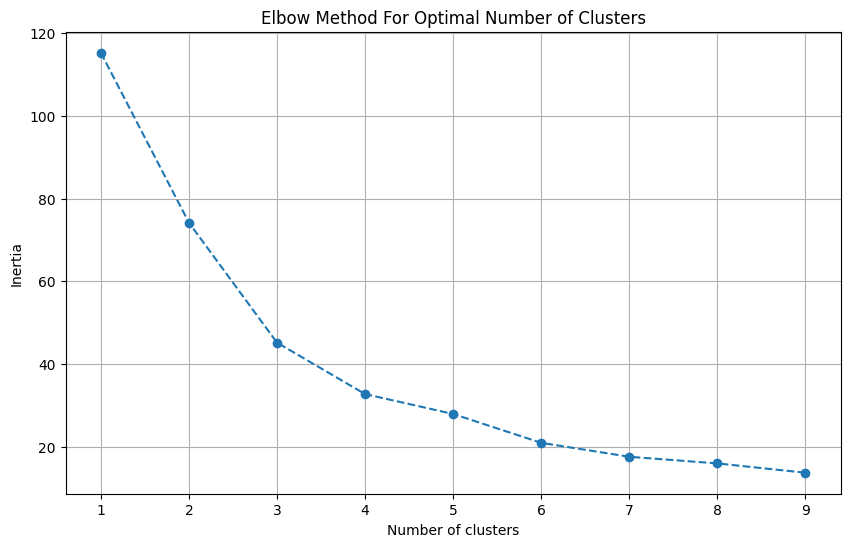

Optimal number of clusters: 1


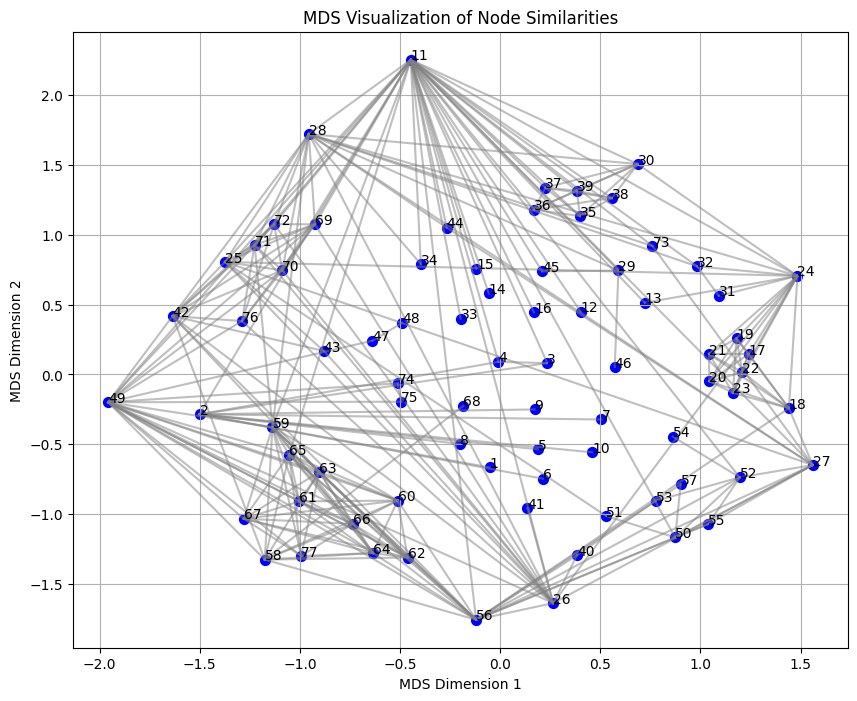

IndexError: index 2 is out of bounds for axis 1 with size 2

In [116]:
def plot_mds(similarities, node_list, edge_list, n_components=2, interactive=False):  
    mds = MDS(n_components=n_components,max_iter=500)
    embeddings = mds.fit_transform(1 - similarities)

    inertias = []
    for k in range(1, min(10, len(node_list))): 
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(embeddings)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, min(10, len(node_list))), inertias, marker='o', linestyle='--')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal Number of Clusters')
    plt.xticks(range(1, min(10, len(node_list))))
    plt.grid(True)
    plt.show()

    optimal_k = np.argmin(np.diff(inertias)) + 1
    kmeans = KMeans(n_clusters=optimal_k)
    print(f"Optimal number of clusters: {optimal_k}") 
    labels = kmeans.fit_predict(embeddings)

    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c='blue', s=50)

    for edge in edge_list:
        u, v = edge
        u_index = node_list.index(u)
        v_index = node_list.index(v)
        plt.plot([embeddings[u_index, 0], embeddings[v_index, 0]], 
                    [embeddings[u_index, 1], embeddings[v_index, 1]], 
                    color='gray', alpha=0.5)

    for i, node_number in enumerate(node_list):
        plt.text(embeddings[i, 0], embeddings[i, 1], node_number, color='black')

    plt.title('MDS Visualization of Node Similarities')
    plt.xlabel('MDS Dimension 1')
    plt.ylabel('MDS Dimension 2')
    plt.grid(True)
    plt.show()

    if interactive:
        trace = go.Scatter3d(
            x=embeddings[:, 0],
            y=embeddings[:, 1],
            z=embeddings[:, 2],
            mode='markers',
            text=node_list,
            hoverinfo='text',
            marker=dict(
                size=5,
                color=labels,
                colorscale='Viridis',
                opacity=0.8
            )
        )
        
        edge_traces = []
        for edge in edge_list:
            u, v = edge
            u_index = node_list.index(u)
            v_index = node_list.index(v)
            edge_trace = go.Scatter3d(
                x=[embeddings[u_index, 0], embeddings[v_index, 0]],
                y=[embeddings[u_index, 1], embeddings[v_index, 1]],
                z=[embeddings[u_index, 2], embeddings[v_index, 2]],
                mode='lines',
                line=dict(color='gray', width=1),
                hoverinfo='none'
            )
            edge_traces.append(edge_trace)
        
        dropdown_buttons = [
            {
                'label': node,
                'method': 'update',
                'args': [
                    {'selectedpoints': [node_list.index(node)]},
                    {'marker.color': ['rgba(255,0,0,1)' if i == node_list.index(node) else 'rgba(0,0,0,1)' for i in range(len(node_list))]}
                ]
            }
            for node in node_list
        ]

        updatemenu = [
            {
                'buttons': dropdown_buttons,
                'direction': 'down',
                'showactive': True,
            }
        ]

        layout = go.Layout(
            scene=dict(
                xaxis=dict(title='MDS Dimension 1'),
                yaxis=dict(title='MDS Dimension 2'),
                zaxis=dict(title='MDS Dimension 3')
            ),
            margin=dict(l=0, r=0, b=0, t=0),
            updatemenus=updatemenu
        )

        fig = go.Figure(data=[trace] + edge_traces, layout=layout)
        fig.show()

plot_mds(similarity_matrix, node_list, edge_list, n_components=2, interactive=True)

# ISOMAP

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:383: UserWarning:

The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/sparse/_index.py:102: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



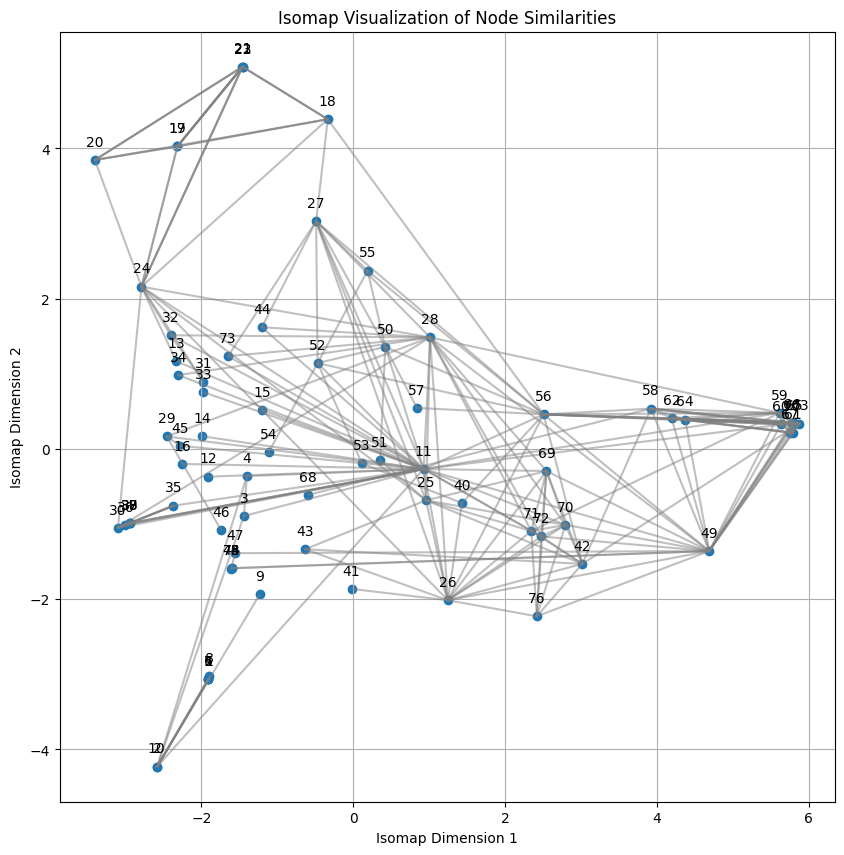

In [210]:
def plot_isomap(similarities, node_list, edge_list, n_components=2, interactive=False):  
    isomap = Isomap(n_components=n_components, max_iter=1000)
    embeddings = isomap.fit_transform(1 - similarities)

    label_map = {label: i for i, label in enumerate(np.unique(node_list))}

    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings[:, 0], embeddings[:, 1])

    for edge in edge_list:
        u, v = edge
        u_index = node_list.index(u)
        v_index = node_list.index(v)
        plt.plot([embeddings[u_index, 0], embeddings[v_index, 0]], 
                 [embeddings[u_index, 1], embeddings[v_index, 1]], 
                 color='gray', alpha=0.5)

    for i, node_number in enumerate(node_list):
        plt.annotate(node_number, (embeddings[i, 0], embeddings[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.title('Isomap Visualization of Node Similarities')
    plt.xlabel('Isomap Dimension 1')
    plt.ylabel('Isomap Dimension 2')
    plt.grid(True)
    plt.show()

    if interactive:
        trace = go.Scatter3d(
            x=embeddings[:, 0],
            y=embeddings[:, 1],
            z=embeddings[:, 2] if n_components == 3 else np.zeros_like(embeddings[:, 0]),
            mode='markers',
            text=node_list,
            hoverinfo='text',
            marker=dict(
                size=5,
                color=[label_map[label] for label in node_list],
                colorscale='Viridis',
                opacity=0.8
            )
        )

        edge_traces = []
        for edge in edge_list:
            u, v = edge
            u_index = node_list.index(u)
            v_index = node_list.index(v)
            edge_trace = go.Scatter3d(
                x=[embeddings[u_index, 0], embeddings[v_index, 0]],
                y=[embeddings[u_index, 1], embeddings[v_index, 1]],
                z=[embeddings[u_index, 2], embeddings[v_index, 2]] if n_components == 3 else np.zeros(2),
                mode='lines',
                line=dict(color='gray', width=1),
                hoverinfo='none'
            )
            edge_traces.append(edge_trace)
        
        dropdown_buttons = [
            {
                'label': node,
                'method': 'update',
                'args': [
                    {'selectedpoints': [node_list.index(node)]},
                    {'marker.color': ['rgba(255,0,0,1)' if i == node_list.index(node) else 'rgba(0,0,0,1)' for i in range(len(node_list))]}
                ]
            }
            for node in node_list
        ]

        updatemenu = [
            {
                'buttons': dropdown_buttons,
                'direction': 'down',
                'showactive': True,
            }
        ]

        layout = go.Layout(
            scene=dict(
                xaxis=dict(title='Isomap Dimension 1'),
                yaxis=dict(title='Isomap Dimension 2'),
                zaxis=dict(title='Isomap Dimension 3' if n_components == 3 else ''),
            ),
            margin=dict(l=0, r=0, b=0, t=0),
            updatemenus=updatemenu
        )

        fig = go.Figure(data=[trace] + edge_traces, layout=layout)
        fig.show()

plot_isomap(similarity_matrix, node_list, edge_list, n_components=2, interactive=True)